In [2]:
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import datetime
import matplotlib.pyplot as plt

In [28]:
import matplotlib.pyplot as plt

In [14]:
from sklearn.preprocessing import LabelEncoder

In [16]:
import math
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [39]:
folder = "/Users/mariabelenalberti/OneDrive - Universidad Torcuato Di Tella/Tesis/datasets/finales/"
filename = "affluent_std copy.csv"
energy_data = read_csv(folder + filename,parse_dates = ['hour'], index_col = ['hour'])
energy_data = energy_data.rename(columns={"energy(kWh/hh)": "energy"})
del energy_data['index']

In [40]:
energy_data.head()

,energy,temperature,pressure,wind_speed,humidity,weekend
hour,,,,,,
2012-01-01 00:00:00,0.234250,13.49,1008.14,3.11,0.88,1
2012-01-01 00:30:00,0.213458,13.49,1008.14,3.11,0.88,1
2012-01-01 01:00:00,0.236750,12.73,1007.88,3.08,0.93,1
2012-01-01 01:30:00,0.207667,12.73,1007.88,3.08,0.93,1
2012-01-01 02:00:00,0.193708,13.65,1007.09,3.71,0.91,1


In [41]:
np.random.seed(11)
dataframe = energy_data.loc[:,'energy']
dataset = dataframe.values
dataset = dataset.astype('float32')

In [42]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [43]:
reframed = series_to_supervised(dataset, 7,1)
reframed.head(3)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,0.234250,0.213458,0.236750,0.207667,0.193708,0.169583,0.153583,0.178833
8,0.213458,0.236750,0.207667,0.193708,0.169583,0.153583,0.178833,0.164708
9,0.236750,0.207667,0.193708,0.169583,0.153583,0.178833,0.164708,0.150500


In [44]:
reframed['temperature'] = energy_data.temperature.values[7:]
reframed['pressure']= energy_data.pressure.values[7:]
reframed['wind_speed']= energy_data.wind_speed.values[7:]
reframed['humidity']= energy_data.humidity.values[7:]
reframed['weekend']= energy_data.weekend.values[7:]

In [45]:
reframed = reframed.reindex(['temperature', 'pressure','wind_speed','humidity','weekend','var1(t-7)', 'var1(t-6)', 'var1(t-5)', 'var1(t-4)', 'var1(t-3)','var1(t-2)', 'var1(t-1)', 'var1(t)'], axis=1)
reframed = reframed.values

In [46]:
scaler = MinMaxScaler(feature_range=(0, 1))
reframed = scaler.fit_transform(reframed)

In [47]:
# split into train and test sets
train = reframed[:(len(reframed)-30), :]
test = reframed[(len(reframed)-30):len(reframed), :]

In [48]:
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [49]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(35003, 1, 12) (35003,) (30, 1, 12) (30,)


Epoch 1/50
 - 2s - loss: 0.0417 - mse: 0.0052 - mae: 0.0417 - mape: 3620.5630
Epoch 2/50
 - 1s - loss: 0.0239 - mse: 0.0012 - mae: 0.0239 - mape: 1207.8289
Epoch 3/50
 - 1s - loss: 0.0222 - mse: 0.0011 - mae: 0.0222 - mape: 907.5420
Epoch 4/50
 - 1s - loss: 0.0218 - mse: 0.0010 - mae: 0.0218 - mape: 808.3937
Epoch 5/50
 - 1s - loss: 0.0215 - mse: 0.0010 - mae: 0.0215 - mape: 777.1217
Epoch 6/50
 - 1s - loss: 0.0213 - mse: 0.0010 - mae: 0.0213 - mape: 823.5986
Epoch 7/50
 - 1s - loss: 0.0212 - mse: 0.0010 - mae: 0.0212 - mape: 663.2292
Epoch 8/50
 - 1s - loss: 0.0211 - mse: 0.0010 - mae: 0.0211 - mape: 740.1911
Epoch 9/50
 - 1s - loss: 0.0211 - mse: 0.0010 - mae: 0.0211 - mape: 791.4427
Epoch 10/50
 - 1s - loss: 0.0210 - mse: 9.9863e-04 - mae: 0.0210 - mape: 787.8642
Epoch 11/50
 - 1s - loss: 0.0210 - mse: 9.9610e-04 - mae: 0.0210 - mape: 788.8464
Epoch 12/50
 - 1s - loss: 0.0209 - mse: 9.9253e-04 - mae: 0.0209 - mape: 781.6694
Epoch 13/50
 - 1s - loss: 0.0208 - mse: 9.8597e-04 - mae: 0

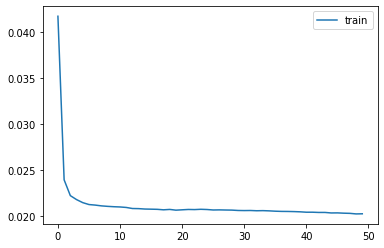

In [66]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics=['mse', 'mae', 'mape'])
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=70, verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show()

In [52]:
# make a prediction
yhat = model.predict(test_X)

In [53]:
test_X = test_X.reshape(test_X.shape[0], test_X.shape[2])

In [54]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)

In [55]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X), axis=1)
inv_y = scaler.inverse_transform(inv_y)

In [56]:
act = [i[9] for i in inv_y] # last element is the predicted average energy
pred = [i[9] for i in inv_yhat] # last element is the actual average energy

# calculate RMSE
import math
rmse = math.sqrt(mean_squared_error(act, pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.000


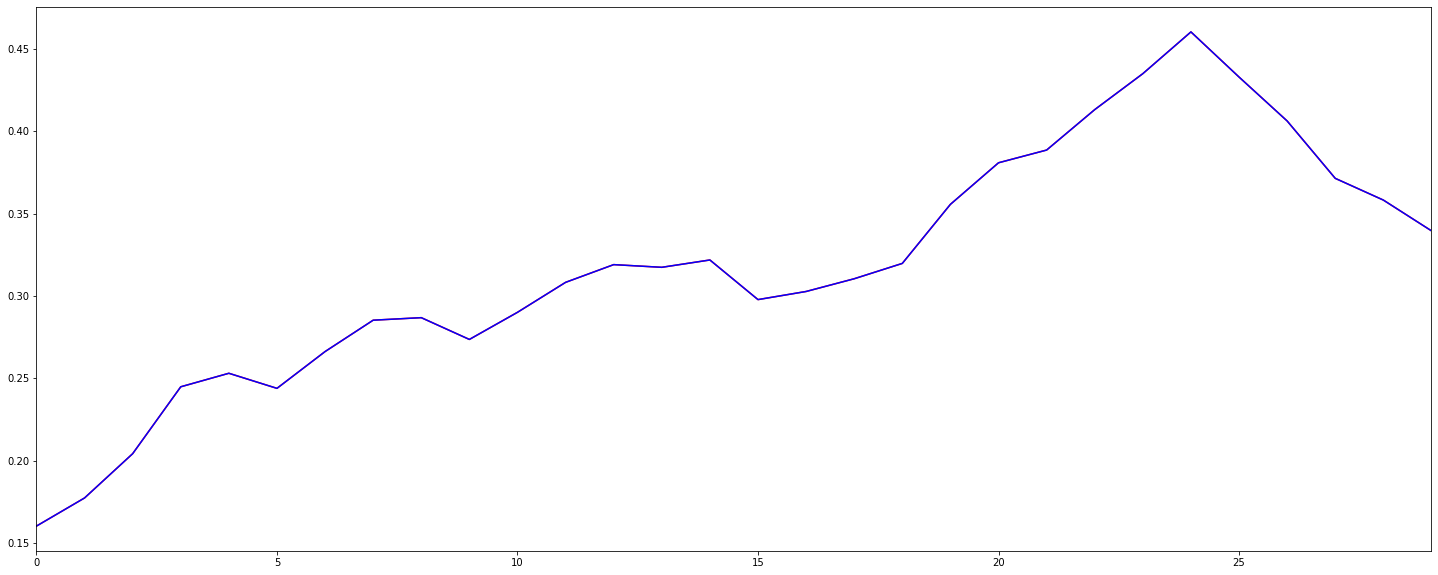

In [57]:
predicted_lstm = pd.DataFrame({'predicted':pred,'avg_energy':act})
predicted_lstm['avg_energy'].plot(figsize=(25,10),color = 'red')
predicted_lstm['predicted'].plot(color = 'blue')
plt.show()

In [74]:
from sklearn import metrics
#MAE
print(metrics.mean_absolute_error(act,pred))

0.0


In [76]:
def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100
print ('My MAPE: ' + str(MAPE(pred,act)) )

TypeError: unsupported operand type(s) for -: 'list' and 'list'